In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
import pickle

In [27]:
df = pd.read_csv('merged.csv')

/tmp/ipykernel_8521/1639747921.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged.csv')


In [28]:
feats = [
    '0.BRIGHTNESS.mean', '0.BRIGHTNESS.std', '0.BRIGHTNESS.max', '0.BRIGHTNESS.min', '0.BRIGHT_T31.mean', '0.BRIGHT_T31.std', '0.BRIGHT_T31.max', 
    '0.BRIGHT_T31.min', '0.FRP.mean', '0.FRP.std', '0.FRP.max', '0.FRP.min', '0.CONFIDENCE.mean', '0.CONFIDENCE.std', '0.CONFIDENCE.max', '0.CONFIDENCE.min', 
    '2.BRIGHTNESS.mean', '2.BRIGHTNESS.std', '2.BRIGHTNESS.max', '2.BRIGHTNESS.min', '2.BRIGHT_T31.mean', '2.BRIGHT_T31.std', '2.BRIGHT_T31.max', '2.BRIGHT_T31.min', 
    '2.FRP.mean', '2.FRP.std', '2.FRP.max', '2.FRP.min', '2.CONFIDENCE.mean', '2.CONFIDENCE.std', '2.CONFIDENCE.max', '2.CONFIDENCE.min', '5.BRIGHTNESS.mean', 
    '5.BRIGHTNESS.std', '5.BRIGHTNESS.max', '5.BRIGHTNESS.min', '5.BRIGHT_T31.mean', '5.BRIGHT_T31.std', '5.BRIGHT_T31.max', '5.BRIGHT_T31.min', '5.FRP.mean', 
    '5.FRP.std', '5.FRP.max', '5.FRP.min', '5.CONFIDENCE.mean', '5.CONFIDENCE.std', '5.CONFIDENCE.max', '5.CONFIDENCE.min', '10.BRIGHTNESS.mean', '10.BRIGHTNESS.std', 
    '10.BRIGHTNESS.max', '10.BRIGHTNESS.min', '10.BRIGHT_T31.mean', '10.BRIGHT_T31.std', '10.BRIGHT_T31.max', '10.BRIGHT_T31.min', '10.FRP.mean', '10.FRP.std', 
    '10.FRP.max', '10.FRP.min', '10.CONFIDENCE.mean', '10.CONFIDENCE.std', '10.CONFIDENCE.max', '10.CONFIDENCE.min', '15.BRIGHTNESS.mean', '15.BRIGHTNESS.std', 
    '15.BRIGHTNESS.max', '15.BRIGHTNESS.min', '15.BRIGHT_T31.mean', '15.BRIGHT_T31.std', '15.BRIGHT_T31.max', '15.BRIGHT_T31.min', '15.FRP.mean', '15.FRP.std', 
    '15.FRP.max', '15.FRP.min', '15.CONFIDENCE.mean', '15.CONFIDENCE.std', '15.CONFIDENCE.max', '15.CONFIDENCE.min', "0.dist", "2.dist", "5.dist", "10.dist", "15.dist",
    "closest.dist", "closest.BRIGHTNESS", "closest.BRIGHT_T31", "closest.FRP", "closest.CONFIDENCE"
]
targets = ['infire_day_1','infire_day_2','infire_day_3','infire_day_4','infire_day_5','infire_day_6','infire_day_7','infire_day_8']

In [29]:
df.head()

,dt,lon_min,lat_min,lon_max,lat_max,lon,lat,grid_index,type_id,type_name,...,0.dist,2.dist,5.dist,10.dist,15.dist,closest.BRIGHTNESS,closest.BRIGHT_T31,closest.FRP,closest.CONFIDENCE,closest.dist
0,2020-05-04,47.6,41.0,47.8,41.2,NaN,NaN,143,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,326.8,281.7,37.3,64.0,795174.882744
1,2021-02-24,47.2,41.2,47.4,41.4,NaN,NaN,891,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-27,47.2,41.2,47.4,41.4,NaN,NaN,891,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-04-01,47.4,41.2,47.6,41.4,NaN,NaN,892,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,313.6,290.2,38.8,46.0,308787.219443
4,2020-03-14,47.6,41.2,47.8,41.4,NaN,NaN,893,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,300.7,277.8,20.7,27.0,41722.199694


In [30]:
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt')

In [31]:
targets = ['infire_day_1','infire_day_2','infire_day_3','infire_day_4','infire_day_5','infire_day_6','infire_day_7','infire_day_8']
df['target'] = (df[targets].sum(axis=1)>0).astype(np.uint8)

In [32]:
df = df.loc[df["is_land"] != 0, :]
df = df.loc[~df[feats].isnull().all(1), :]

In [33]:
df.fillna(0, inplace=True)

In [34]:
df.head()

,lon_min,lat_min,lon_max,lat_max,lon,lat,grid_index,type_id,type_name,is_land,...,2.dist,5.dist,10.dist,15.dist,closest.BRIGHTNESS,closest.BRIGHT_T31,closest.FRP,closest.CONFIDENCE,closest.dist,target
dt,,,,,,,,,,,,,,,,,,,,,
2021-04-01,47.4,41.2,47.6,41.4,0.0,0.0,892,0.0,0,True,...,0.0,0.0,0.0,0.0,313.6,290.2,38.8,46.0,308787.219443,0
2020-03-14,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,0.0,300.7,277.8,20.7,27.0,41722.199694,0
2020-04-22,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,0.0,318.0,297.5,30.7,63.0,522742.855859,0
2020-05-20,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,0.0,358.3,292.8,507.4,99.0,476905.454927,0
2020-08-26,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,0.0,308.9,293.4,39.8,43.0,309019.727431,0


In [35]:
df["month"] = df.index.month

In [36]:
df.shape

(347316, 112)

In [37]:
df.head()

,lon_min,lat_min,lon_max,lat_max,lon,lat,grid_index,type_id,type_name,is_land,...,5.dist,10.dist,15.dist,closest.BRIGHTNESS,closest.BRIGHT_T31,closest.FRP,closest.CONFIDENCE,closest.dist,target,month
dt,,,,,,,,,,,,,,,,,,,,,
2021-04-01,47.4,41.2,47.6,41.4,0.0,0.0,892,0.0,0,True,...,0.0,0.0,0.0,313.6,290.2,38.8,46.0,308787.219443,0,4
2020-03-14,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,300.7,277.8,20.7,27.0,41722.199694,0,3
2020-04-22,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,318.0,297.5,30.7,63.0,522742.855859,0,4
2020-05-20,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,358.3,292.8,507.4,99.0,476905.454927,0,5
2020-08-26,47.6,41.2,47.8,41.4,0.0,0.0,893,0.0,0,True,...,0.0,0.0,0.0,308.9,293.4,39.8,43.0,309019.727431,0,8


/home/imd/miniconda3/envs/wildfires/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


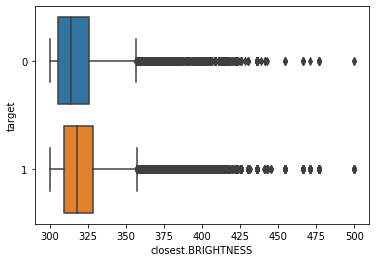

In [38]:
sns.boxplot(df["closest.BRIGHTNESS"], df["target"], orient="h");

In [42]:
class ModelBuilder:
    def __init__(self, df, target, feats, cat_feats):
        self.df = df
        self.target = target
        self.feats = feats
        self.cat_feats = cat_feats
        self.mode = 'classification' if type(target)==str else 'multiclassification'
            
    def train_folds(self, train_size=120, test_size=30, iterations=1000, early_stopping=False):
        if self.mode == 'classification':
            oof_preds = np.zeros(self.df.shape[0])
        else:
            oof_preds = np.zeros((self.df.shape[0], len(targets)))
            
        folds_mask = np.zeros(oof_preds.shape[0])
        cv = TimeSeriesSplit(test_size=10000)
        for fold_, (train_index, test_index) in enumerate(cv.split(self.df)):
            X_train, y_train = self.df.iloc[train_index,:][self.feats], self.df.iloc[train_index,:][self.target]
            X_val, y_val = self.df.iloc[test_index,:][self.feats], self.df.iloc[test_index,:][self.target]

            weeks_train = X_train.reset_index()['dt']
            weeks_test = X_val.reset_index()['dt']

            tr_start_week = weeks_train.min()
            tr_end_week = weeks_train.max()
            ts_start_week = weeks_test.min()
            ts_end_week = weeks_test.max()
            
            print()
            print()
            print(f'Fold {fold_} train ({tr_start_week}, {tr_end_week}) test ({ts_start_week}, {ts_end_week})')
            
            
            cat_model = CatBoostClassifier(
                iterations=iterations,
                learning_rate=0.01,
                metric_period=500,
                loss_function='Logloss' if self.mode=='classification' else 'MultiLogloss',
                l2_leaf_reg=10,
                eval_metric='F1' if self.mode=='classification' else 'MultiLogloss', 
                task_type='CPU',
                early_stopping_rounds=100,
                random_seed=1234,
                use_best_model=early_stopping,
                verbose=False,
                class_weights={0: 3, 1: 1}
            )
            
            print('Train catboost')
            cat_model.fit(X_train, y_train)
            
            if self.mode == 'classification':
                preds = cat_model.predict_proba(X_val)[:,1]
                print()
                print(f'Fold {fold_} F1 Score ', metrics.f1_score(y_val, preds.round()))
                print(f'Fold {fold_} ROC AUC Score ', metrics.roc_auc_score(y_val, preds.round()))
                print(f'Fold {fold_} Confusion matrix')
                print(metrics.confusion_matrix(y_val, preds.round()))
                oof_preds[test_index] = preds
            else:
                oof_preds[test_index] = cat_model.predict(X_val)
                print(f'Fold {fold_} F1 Score ', metrics.f1_score(y_val, oof_preds[test_index].round(), average='micro'))
                try:
                    print(f'Fold {fold_} ROC AUC Score ', metrics.roc_auc_score(y_val, oof_preds[test_index]))
                except ValueError:
                    print(f'Fold {fold_} ROC AUC Score ', 0)
                    
            folds_mask[test_index] = 1
        
        if self.mode == 'classification':
            oof_f1micro = metrics.f1_score(self.df.iloc[folds_mask==1,:][self.target], oof_preds[folds_mask==1].round(), average='micro')
            oof_f1micro = metrics.roc_auc_score(self.df.iloc[folds_mask==1,:][self.target], oof_preds[folds_mask==1], average='micro')
        else:
            oof_f1micro = metrics.f1_score(self.df.iloc[folds_mask==1,:][self.target], oof_preds[folds_mask==1].round(), average='micro')
            oof_f1micro = metrics.roc_auc_score(self.df.iloc[folds_mask==1,:][self.target], oof_preds[folds_mask==1], average='micro')
        
        print()
        print('Overall OOF F1 Micro ', oof_f1micro)
        print('Overall OOF Mean ROC AUC Score ', oof_f1micro)
        
    def train_final_model(self, iterations=1000, early_stopping=False):
        if self.mode == 'classification':
            X_train, y_train = self.df.iloc[:,:][self.feats], self.df.iloc[:,:][self.target]

            cv = TimeSeriesSplit(test_size=10000)

            cat_model = CatBoostClassifier(
                iterations=iterations,
                learning_rate=0.01,
                metric_period=500,
                loss_function='Logloss' if self.mode=='classification' else 'MultiLogloss',
                l2_leaf_reg=10,
                eval_metric='F1' if self.mode=='classification' else 'MultiLogloss', 
                task_type='CPU',
                early_stopping_rounds=100,
                random_seed=1234,
                use_best_model=early_stopping,
                verbose=False,
                class_weights={0: 3, 1: 1}
            )
            cat_model.fit(X_train, y_train)
            
            return cat_model
            
        elif self.mode == 'multiclassification':
            raise NotImplementedError 

### Single lable (will we see fire during a period of 8 days)

In [43]:
fire_model = ModelBuilder(df, 'target', feats, [])

In [44]:
fire_model.train_folds(train_size=210, test_size=30, iterations=1000, early_stopping=False)



Fold 0 train (2020-01-04 00:00:00, 2021-04-14 00:00:00) test (2020-01-04 00:00:00, 2021-04-14 00:00:00)
Train catboost


Custom logger is already specified. Specify more than one logger at same time is not thread safe.


Fold 0 F1 Score  0.8338042213727772
Fold 0 ROC AUC Score  0.7996867316995797
Fold 0 Confusion matrix
[[2983  753]
 [1247 5017]]


Fold 1 train (2020-01-04 00:00:00, 2021-04-14 00:00:00) test (2020-01-04 00:00:00, 2021-04-14 00:00:00)
Train catboost

Fold 1 F1 Score  0.8167503617329136
Fold 1 ROC AUC Score  0.7864934621603454
Fold 1 Confusion matrix
[[3049  790]
 [1363 4798]]


Fold 2 train (2020-01-04 00:00:00, 2021-04-14 00:00:00) test (2020-01-04 00:00:00, 2021-04-14 00:00:00)
Train catboost

Fold 2 F1 Score  0.8329117690819818
Fold 2 ROC AUC Score  0.7678739640443583
Fold 2 Confusion matrix
[[2156  718]
 [1528 5598]]


Fold 3 train (2020-01-04 00:00:00, 2021-04-14 00:00:00) test (2020-01-04 00:00:00, 2021-04-14 00:00:00)
Train catboost

Fold 3 F1 Score  0.8304913294797688
Fold 3 ROC AUC Score  0.7486556473424392
Fold 3 Confusion matrix
[[1907  769]
 [1577 5747]]


Fold 4 train (2020-01-04 00:00:00, 2021-04-14 00:00:00) test (2020-01-04 00:00:00, 2021-04-14 00:00:00)
Train catboost


In [45]:
cat_model = fire_model.train_final_model()

In [46]:
with open("../models/model.pkl", "wb") as f:
    pickle.dump(cat_model, f)